# PCA of EEG Features (Dortmund Dataset)
This notebook describes the process of applying PCA to EEG-derived features, exploring dimensionality reduction, and preparing data for clustering.

- Objective: Reduce high-dimensional EEG features to a lower-dimensional space to explore participant variability.
- Dataset: Dortmund dataset (608 participants, multiple EEG features).
- Goals:
  1. Understand structure of the features.
  2. Perform PCA for dimensionality reduction.
  3. Explore variance explained by principal components.
  4. Prepare data for clustering and visualization.

## Load Data
Load the Dortmund dataset and inspect the first few rows.

In [1]:
import pandas as pd
import numpy as np

dort = pd.read_csv("./dataset/Dortmund_features.csv", index_col=0)  # Keep subject IDs as index!
age_sex_dort = pd.read_csv("./dataset/Dortmund_age&sex.csv", index_col=0)
# Extract age and sex
age_dort = age_sex_dort['age'].values
sex_dort = age_sex_dort['sex'].values

lemon = pd.read_csv("./dataset/Lemon_features.csv", index_col=0)  # Keep subject IDs as index!
age_sex_lemon = pd.read_csv("./dataset/Lemon_age&sex.csv", index_col=0)
# Extract age and sex
age_lemon = age_sex_lemon['age_group'].values # note ages are ranges in Lemon
sex_lemon = age_sex_lemon['sex'].values

## 1. Exploratory Data Analysis
- Preview first few rows and numeric columns.
- Check for missing values.
- Examine feature distributions.

In [2]:
# Print dataset shapes
print(f"Dortmund_features.csv shape: {dort.shape}")
print(f"LEMON_features.csv shape: {lemon.shape}\n")

dort_cols = set(dort.columns)
lemon_cols = set(lemon.columns)

print("Features only in Dortmund:")
print(dort_cols - lemon_cols, "\n")

print("Features only in LEMON:")
print(lemon_cols - dort_cols, "\n")


Dortmund_features.csv shape: (600, 147)
LEMON_features.csv shape: (190, 147)

Features only in Dortmund:
set() 

Features only in LEMON:
set() 



All features are shared in Dortmund and Lemon

1. Scatter Plot of First Two Raw Features


Plotting the first two numeric features:
Feature 1: nl_rqa mean diag length
Feature 2: kurtosis_amp_theta



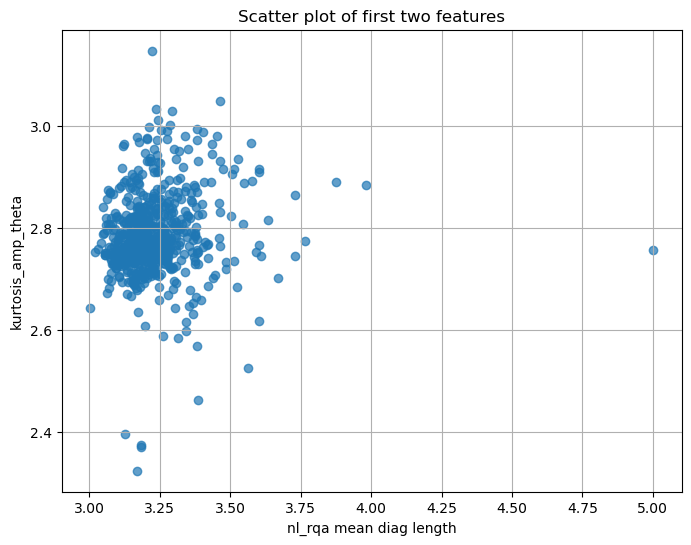

In [3]:
import matplotlib.pyplot as plt

# Select only numeric columns (exclude IDs or non-numeric)
numeric_data = dort.select_dtypes(include=['float64', 'int64'])
dort_numeric = numeric_data.values

# Define features (all numeric columns)
features = dort_numeric  # shape: (participants, features)

# Print what we are plotting
print("Plotting the first two numeric features:")
print(f"Feature 1: {numeric_data.columns[0]}")
print(f"Feature 2: {numeric_data.columns[1]}\n")

# Scatter plot of first two features
plt.figure(figsize=(8,6))
plt.scatter(features[:, 0], features[:, 1], alpha=0.7)
plt.xlabel(numeric_data.columns[0])
plt.ylabel(numeric_data.columns[1])
plt.title("Scatter plot of first two features")
plt.grid(True)
plt.show()


2. Feature-Age/Sex Relationship
-   **Age** — plotted using scatter plots  
-   **Sex** — plotted using boxplots (female vs male)

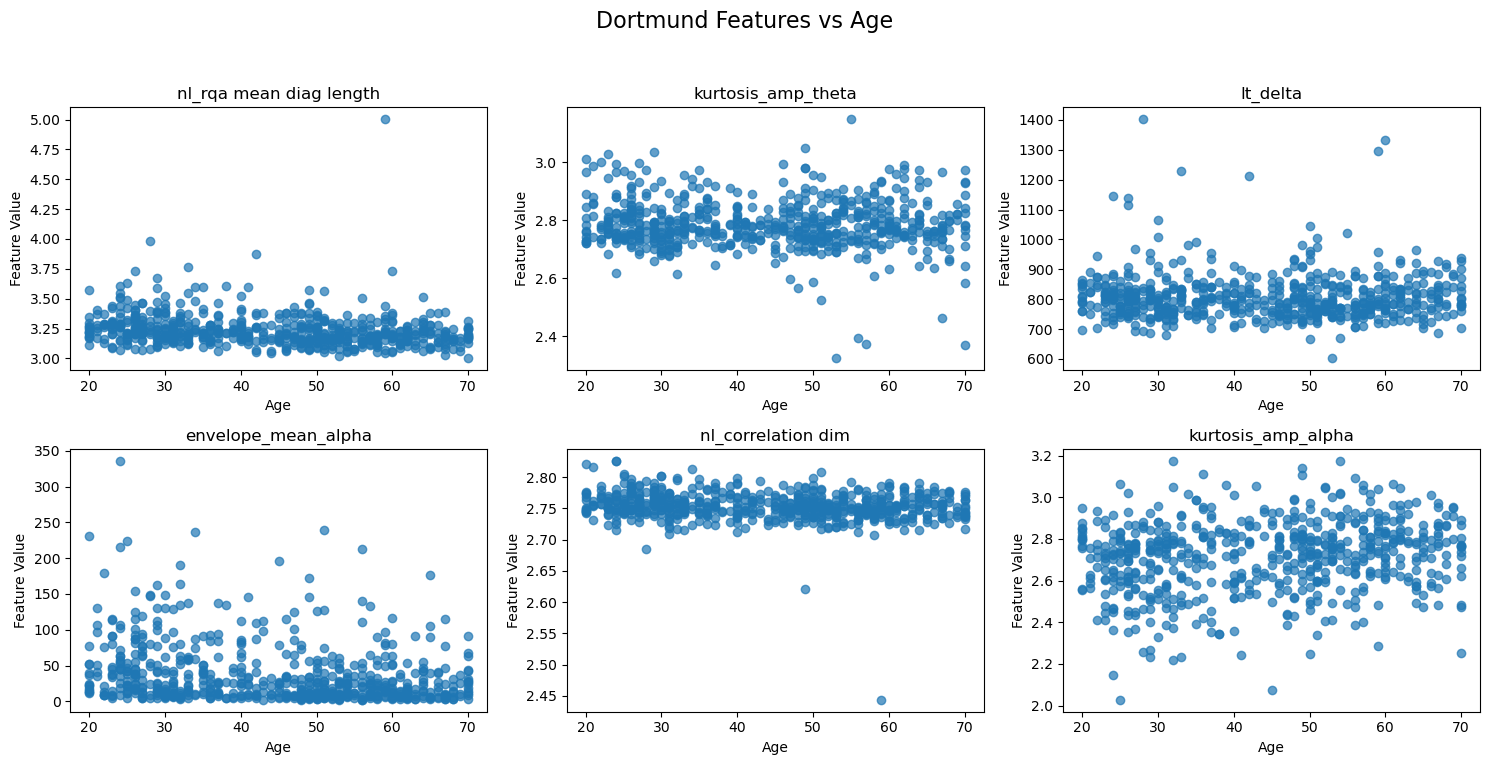

/var/folders/8g/xxs_fk6n0wx22j3lv0pzth1m0000gn/T/ipykernel_89673/479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
/var/folders/8g/xxs_fk6n0wx22j3lv0pzth1m0000gn/T/ipykernel_89673/479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
/var/folders/8g/xxs_fk6n0wx22j3lv0pzth1m0000gn/T/ipykernel_89673/479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dor

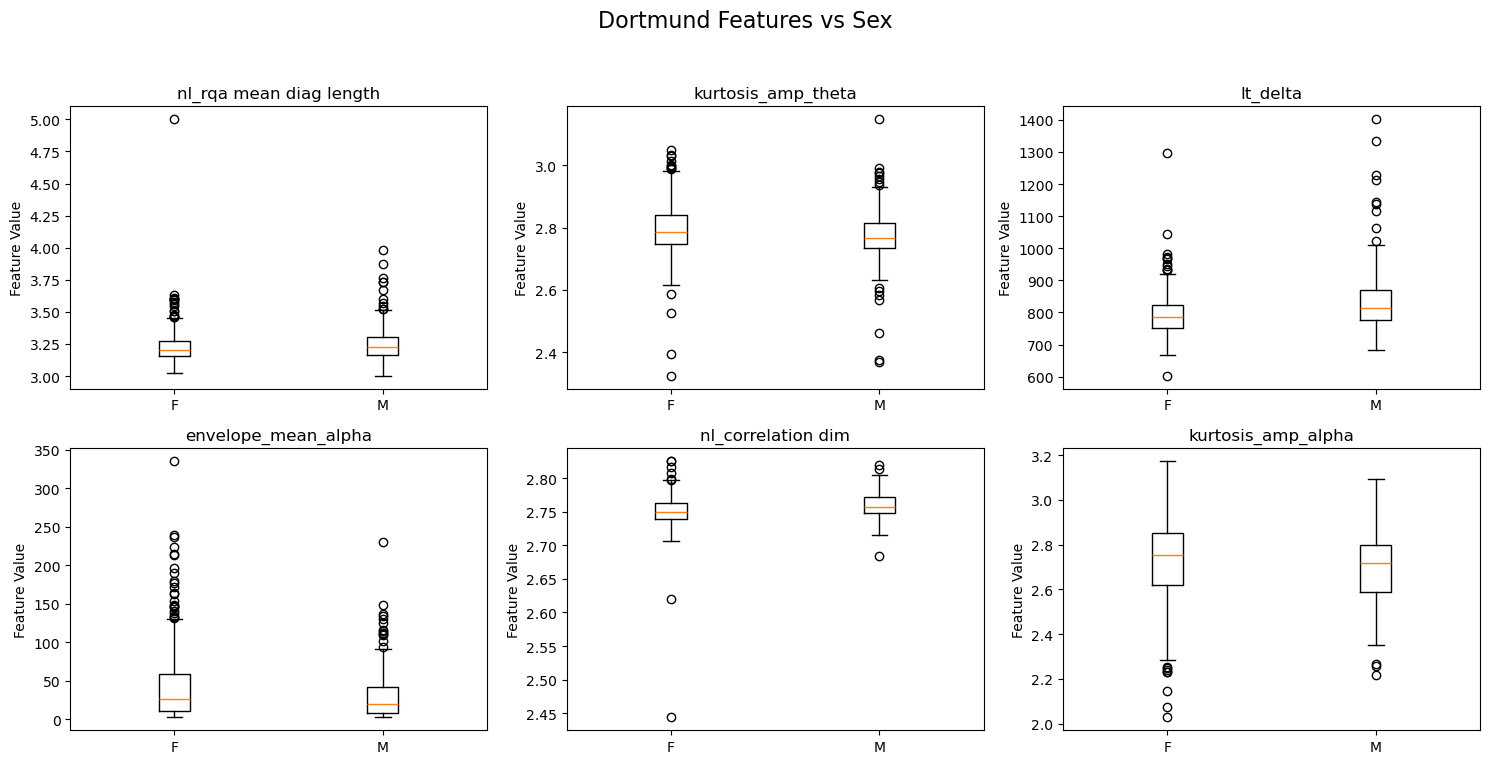

In [4]:
# Numeric Dortmund features
dort_numeric = dort.select_dtypes(include=['float64', 'int64'])
num_features_to_plot = 6

# -------------------------
# Plot features vs Age
# -------------------------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i in range(num_features_to_plot):
    axes[i].scatter(age_dort, dort_numeric.iloc[:, i], alpha=0.7)
    axes[i].set_title(dort_numeric.columns[i])
    axes[i].set_xlabel("Age")
    axes[i].set_ylabel("Feature Value")

plt.suptitle("Dortmund Features vs Age", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# -------------------------
# Plot features vs Sex
# -------------------------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i in range(num_features_to_plot):
    axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
                    labels=['F','M'])
    axes[i].set_title(dort_numeric.columns[i])
    axes[i].set_ylabel("Feature Value")

plt.suptitle("Dortmund Features vs Sex", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 2. Principal Component Analysis (PCA)
- Reduce dimensionality to an optimal number of PCs for clustering while optionally visualizing in 2D.
- Examine explained variance, singular values, and component loadings to understand feature contributions.


1. Standardize Features
- PCA is sensitive to scale, so all numeric features are standardized to mean = 0 and variance = 1 before PCA.

2. Optimal PCA Computation
- Compute full PCA and determine the minimum number of PCs needed to reach a threshold variance (default 80%).
- Plot cumulative explained variance and scree plot to visualize the variance captured by each component.

3.  PCA Component Loadings & Transformed Data
- Loadings indicate how strongly each original feature contributes to each principal component.
- Transformed PCA data (scores) are used for clustering.
- Optionally export loadings and PCA-transformed dataset for further analysis.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def run_optimal_pca(data, threshold=0.8, dataset_name="Dataset", export=False):
    """
    Standardizes data, computes full PCA, finds optimal PCs using cumulative variance,
    plots PCA results, and returns PCA-transformed data and components.
    
    Parameters:
        data : pandas DataFrame (numeric)
        threshold : float, e.g. 0.8 for 80% variance
        dataset_name : str (used in plot titles)
        
    Returns:
        pca_optimal_components : np.array (PCA-transformed data)
        pca_model_optimal : PCA object fitted with optimal n_components
        num_pcs_threshold : int (optimal number of PCs)
        explained_variance_full : np.array (all PCs variance)
        components_optimal : np.array (loadings)
    """

    # 1. Standardize
    scaled = StandardScaler().fit_transform(data)

    # 2. Full PCA
    pca_full = PCA()
    pca_full.fit(scaled)

    explained_variance_full = pca_full.explained_variance_ratio_
    cumulative = np.cumsum(explained_variance_full)

    # 3. Determine optimal PCs
    num_pcs_threshold = np.argmax(cumulative >= threshold) + 1

    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Cumulative plot
    axes[0].plot(range(1, len(cumulative)+1), cumulative*100, marker='o')
    axes[0].axvline(num_pcs_threshold, color='r', linestyle='--',
                    label=f'{int(threshold*100)}% at PC{num_pcs_threshold}')
    axes[0].set_title(f"{dataset_name}: Cumulative Explained Variance")
    axes[0].set_xlabel("Number of Principal Components")
    axes[0].set_ylabel("Cumulative Explained Variance (%)")
    axes[0].legend()
    axes[0].grid(True)

    # Scree plot
    axes[1].plot(range(1, len(explained_variance_full)+1),
                 explained_variance_full*100, marker='o', alpha=0.7)
    axes[1].axhline(explained_variance_full[num_pcs_threshold-1]*100,
                    color='r', linestyle='--',
                    label=f'PC{num_pcs_threshold} variance')
    axes[1].set_title(f"{dataset_name}: Scree Plot")
    axes[1].set_xlabel("Principal Component")
    axes[1].set_ylabel("Explained Variance (%)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # 4. Run optimal PCA
    pca_optimal = PCA(n_components=num_pcs_threshold)
    transformed = pca_optimal.fit_transform(scaled)

    # --- Printing ---
    print(f"\n=== {dataset_name}: Optimal PCA Summary ===")
    print(f"Optimal number of PCs for {int(threshold*100)}% variance: {num_pcs_threshold}")
    print(f"Variance explained by PC1: {explained_variance_full[0]*100:.2f}%")
    print(f"Total variance explained by {num_pcs_threshold} PCs: {cumulative[num_pcs_threshold-1]*100:.2f}%\n")

    print("\n=== Explained Variance of Optimal PCs ===")
    for i, v in enumerate(pca_optimal.explained_variance_ratio_, start=1):
        print(f"PC{i}: {v*100:.2f}%")

    print("\n=== First 5 Singular Values ===")
    print(pca_optimal.singular_values_[:5])

    print("\n=== PCA Loadings (First 3 Features Per PC) ===")
    for i, pc in enumerate(pca_optimal.components_, start=1):
        print(f"PC{i}: {pc[:3]}")


    # --------------------------- #
    # 5. Optional export to CSV
    # --------------------------- #
    # --------------------------- #
    # 5. Optional export to CSV
    # --------------------------- #
    if export:
        # --- PCA Components (Loadings) ---
        # Rows = PCs, Columns = original features
        # This shows HOW MUCH each original feature contributes to each PC
        loadings_df = pd.DataFrame(
            pca_optimal.components_,
            columns=data.columns,
            index=[f"PC{i+1}" for i in range(num_pcs_threshold)]
        )
        loadings_path = f"dataset/{dataset_name}_pca_loadings.csv"
        loadings_df.to_csv(loadings_path, index=True)

        # --- PCA Transformed Data ---
        # Rows = Subjects, Columns = PCs
        # This is what you use for CLUSTERING
        transformed_df = pd.DataFrame(
            transformed,
            index=data.index, # Keep original subject IDs!
            columns=[f"PC{i+1}" for i in range(num_pcs_threshold)]
        )
        transformed_path = f"dataset/{dataset_name}_pca.csv"
        transformed_df.to_csv(transformed_path, index=True)

        print(f"\n✓ Exported loadings to:     {loadings_path}")
        print(f"✓ Exported PCA scores to:   {transformed_path}")
        print(f"  Subject IDs preserved: {transformed_df.index[:3].tolist()}... (first 3)")

    return transformed, pca_optimal, num_pcs_threshold, explained_variance_full, pca_optimal.components_


OPTIMAL PCA (DORTMUND DATASET):

data_pca      → The PCA-transformed dataset (participants × optimal PCs).
                These are the coordinates of each subject in PCA space.

data_model    → The fitted PCA model object.
                Contains components_, explained_variance_ratio_, singular_values_, etc.

data_nPC      → The optimal number of principal components selected automatically.
                Determined by reaching the cumulative variance threshold (e.g., 80%).

data_var      → Explained variance ratio of each selected PC.
                Tells you how much variance each principal component captures.

data_loadings → PCA loadings (components): contribution of each original feature to each PC.
                Shape = (nPC × n_features). Used for interpretation and clustering.

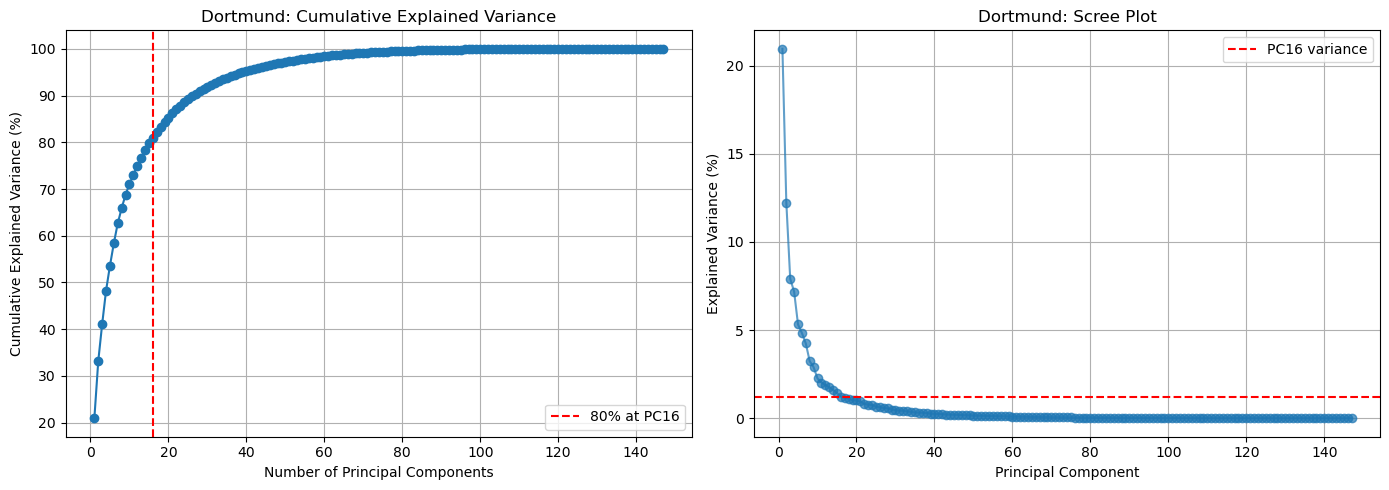


=== Dortmund: Optimal PCA Summary ===
Optimal number of PCs for 80% variance: 16
Variance explained by PC1: 20.95%
Total variance explained by 16 PCs: 80.96%


=== Explained Variance of Optimal PCs ===
PC1: 20.95%
PC2: 12.23%
PC3: 7.91%
PC4: 7.18%
PC5: 5.32%
PC6: 4.83%
PC7: 4.24%
PC8: 3.23%
PC9: 2.90%
PC10: 2.26%
PC11: 2.02%
PC12: 1.89%
PC13: 1.76%
PC14: 1.61%
PC15: 1.43%
PC16: 1.22%

=== First 5 Singular Values ===
[135.92426733 103.85380041  83.50298096  79.57932546  68.48214741]

=== PCA Loadings (First 3 Features Per PC) ===
PC1: [ 0.07755219  0.03162876 -0.02748839]
PC2: [-0.17531187 -0.01302002 -0.1249459 ]
PC3: [-0.05803027 -0.0689386  -0.13057856]
PC4: [-0.01288436  0.02623848 -0.09575203]
PC5: [ 0.06350053 -0.12897441 -0.02706761]
PC6: [0.0337689  0.01407663 0.08135285]
PC7: [0.08087103 0.08480622 0.04429483]
PC8: [-0.07384499  0.09185317 -0.09997992]
PC9: [0.00617356 0.067687   0.07687908]
PC10: [-0.02052097 -0.11688603 -0.03650611]
PC11: [0.0050316  0.23617951 0.1038435 ]
P

In [6]:
dort_numeric = dort.select_dtypes(include=['float64', 'int64'])
dort_pca, dort_model, dort_nPC, dort_var, dort_loadings = run_optimal_pca(
    dort_numeric,
    threshold=0.80,
    dataset_name="Dortmund",
    export=True
)

OPTIMAL PCA (LEMON DATASET):

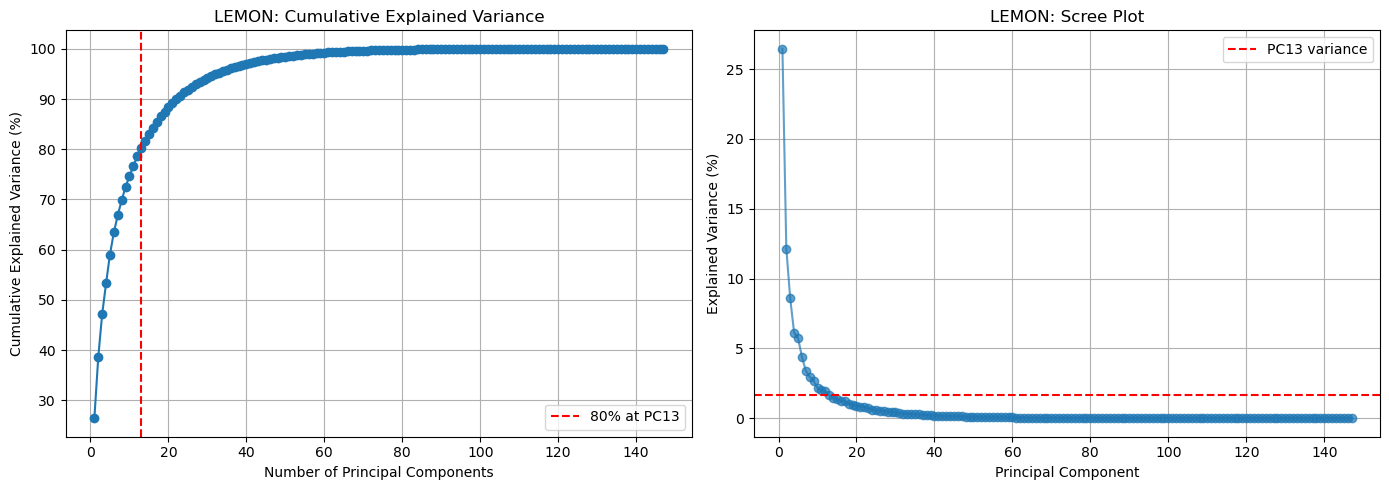


=== LEMON: Optimal PCA Summary ===
Optimal number of PCs for 80% variance: 13
Variance explained by PC1: 26.45%
Total variance explained by 13 PCs: 80.24%


=== Explained Variance of Optimal PCs ===
PC1: 26.45%
PC2: 12.15%
PC3: 8.57%
PC4: 6.13%
PC5: 5.75%
PC6: 4.41%
PC7: 3.40%
PC8: 2.96%
PC9: 2.68%
PC10: 2.15%
PC11: 2.01%
PC12: 1.93%
PC13: 1.64%

=== First 5 Singular Values ===
[85.9498367  58.24597055 48.9346571  41.37887684 40.0681235 ]

=== PCA Loadings (First 3 Features Per PC) ===
PC1: [0.1183683  0.00626448 0.06426968]
PC2: [-0.01681211  0.05213916 -0.10845719]
PC3: [ 0.04190047 -0.01404165  0.09092072]
PC4: [-0.00944458  0.11810503  0.12506928]
PC5: [0.15848921 0.02815616 0.03572152]
PC6: [-0.0697668  -0.02414548 -0.02613632]
PC7: [ 0.03277971  0.0790457  -0.14885173]
PC8: [-0.02086367 -0.14332598  0.05058819]
PC9: [ 0.00972326  0.17819356 -0.03012205]
PC10: [ 0.07506859 -0.07097608  0.02327065]
PC11: [-0.00868137 -0.18580685 -0.04964539]
PC12: [ 0.00321458 -0.22565086  0.10436

In [7]:
lemon_numeric = lemon.select_dtypes(include=['float64', 'int64'])
lemon_pca, lemon_model, lemon_nPC, lemon_var, lemon_loadings = run_optimal_pca(
    lemon_numeric,
    threshold=0.8,
    dataset_name="LEMON",
    export=True
)


## 3. PCA Stability Analysis: Bootstrap 
To assess the stability of PCA-derived feature subspaces for two datasets (Dortmund and Lemon) - understand how robust the principal components are to sampling variability

1. **Bootstrap Resampling:**  
 - For each dataset, we create `n_boot` resampled datasets by sampling subjects with replacement.
- PCA is applied to each resampled dataset, keeping components that explain 99% of the variance.

2. **Subspace Comparison:**  
- For each pair of bootstrap PCA results within the same dataset, we compute the singular values of the matrix product between their component matrices.
- Singular values close to 1 = nearly identical subspaces (high stability)
- Also compute singular values between Dortmund and Lemon bootstraps to see how similar the feature subspaces are across datasets.

In [8]:
from numpy.linalg import svd
from sklearn.utils import resample

def bootstrap_pca(X, n_boot, variance_threshold=0.99):
    """
    Compute PCA on multiple bootstrap resamples of the dataset to assess stability.
    
    Parameters:
    - X: array-like, shape (n_samples, n_features)
        The data matrix to analyze.
    - n_boot: int
        Number of bootstrap resamples.
    - variance_threshold: float
        Fraction of variance to retain in PCA.
    
    Returns:
    - components_boot: list of arrays
        Each array contains PCA components for one bootstrap sample (shape: n_features x n_components).
    - min_n_comp: int
        Minimum number of components across all bootstrap samples.
    """

    n_samples, n_features = X.shape
    components_boot = []
    min_n_comp = n_features

    for i in range(n_boot):
        # Resample rows (participants) with replacement
        X_resampled = resample(X, random_state=i)

        # Standardize resampled data
        X_scaled = StandardScaler().fit_transform(X_resampled)

        # Fit PCA to bootstrap-sampled data
        pca = PCA(n_components=variance_threshold)
        pca.fit(X_scaled)

        # Store the component vectors
        components_boot.append(pca.components_.T)   # shape: features × components
        
        # Keep track of minimum number of components across bootstraps
        min_n_comp = np.min((min_n_comp, len(pca.components_)))

    return components_boot, min_n_comp



def singular_values(mat1, mat2):
    """
    Measure similarity between two PCA component matrices using singular values.
    
    Parameters:
    - mat1, mat2: arrays of shape (n_features, n_components)
    
    Returns:
    - Array of singular values representing alignment of subspaces.
    """

    M = mat1.T @ mat2
    _, s, _ = svd(M)
    return s

In [46]:
# Number of bootstrap iterations
n_boot = 200  # For readability in examples; typically use >=100 in actual analysis

# Variance threshold for bootstrap PCA (use 0.80 to match the 80% threshold used in main PCA)
bootstrap_variance_threshold = 0.80

# Run bootstrap PCA on Dortmund and LEMON datasets
dort_comp, min_dort = bootstrap_pca(dort, n_boot, variance_threshold=bootstrap_variance_threshold)
lem_comp, min_lem = bootstrap_pca(lemon, n_boot, variance_threshold=bootstrap_variance_threshold)

# Find the minimum number of components across all bootstraps/datasets
min_n_comp = np.min((min_dort, min_lem))

# Trim each bootstrap PCA result to have the same number of components to allow to compare subspaces using singular values
dort_comp = [boot[:, :min_n_comp] for boot in dort_comp]
lem_comp = [boot[:, :min_n_comp] for boot in lem_comp]
# have aligned PCA bases of shape (features, min_n_com

In [47]:
# Initialize dictionary to store singular values
results = {
    "within_Dortmund": {},
    "within_Lemon": {},
    "between_DL": {}
}

# Compute singular values within bootstraps:
# within Dortmund
for i, boot1 in enumerate(dort_comp):
    for j, boot2 in enumerate(dort_comp):
        if j > i: # only upper-triangle comparisons to avoid duplicates
            results["within_Dortmund"][f"boots {i}-{j}"] = singular_values(boot1, boot2)

# within Lemon
for i, boot1 in enumerate(lem_comp):
    for j, boot2 in enumerate(lem_comp):
        if j > i:
            results["within_Lemon"][f"boots {i}-{j}"] = singular_values(boot1, boot2)

# cross dataset
for i, boot1 in enumerate(dort_comp):
    for j, boot2 in enumerate(lem_comp):
        if j >= i: # compare each Dortmund bootstrap to corresponding or later LEMON bootstraps
            results["between_DL"][f"boots {i}-{j}"] = singular_values(boot1, boot2)


### Results

##### Within-Dataset Stability (Lemon-Lemon or Dortmund): 
All within-Lemon bootstrap similarity distributions fall extremely close to **1.0**, with most values in the range **0.98–1.00**.  
This indicates:
- *High cluster stability:* each component is internally consistent.
- *Robust centroid estimation:* resampling does not meaningfully shift the cluster centers.
- *Well-separated structure:* there is no sign of component collapse or merging.

In short, the Lemon dataset exhibits **very strong internal reproducibility**.

In [48]:
# Display results
# - High singular values (~1) indicate strong alignment of PCA subspaces
# - Lower singular values indicate differences between subspaces

results["within_Dortmund"]

{'boots 0-1': array([0.99825283, 0.99667574, 0.99517491, 0.99430057, 0.99173029,
        0.99021367, 0.98516593, 0.96131726, 0.95351594, 0.87169907,
        0.40798062]),
 'boots 0-2': array([0.99861529, 0.9968404 , 0.99600684, 0.99377668, 0.98876614,
        0.98791887, 0.98311282, 0.97215078, 0.9394583 , 0.88793535,
        0.74455232]),
 'boots 0-3': array([0.99783411, 0.99593143, 0.99435463, 0.99217493, 0.98721818,
        0.98567177, 0.98416207, 0.96785239, 0.96030574, 0.81930044,
        0.44711185]),
 'boots 0-4': array([0.99829156, 0.99689274, 0.99640019, 0.99367821, 0.98977145,
        0.98814484, 0.98556137, 0.98442233, 0.91747214, 0.8756683 ,
        0.65887788]),
 'boots 0-5': array([0.99805379, 0.99640281, 0.99564645, 0.99318575, 0.98712132,
        0.98457478, 0.97846593, 0.97542698, 0.93841974, 0.81426823,
        0.65785458]),
 'boots 0-6': array([0.99782962, 0.99703479, 0.9955978 , 0.99337293, 0.98884644,
        0.98691508, 0.98027335, 0.96313039, 0.95926281, 0.765617

In [49]:
results["within_Lemon"]

{'boots 0-1': array([0.99503786, 0.99400501, 0.99013464, 0.98732071, 0.9731624 ,
        0.9615694 , 0.95704912, 0.92794231, 0.85054219, 0.84417222,
        0.35123898]),
 'boots 0-2': array([0.99533581, 0.99407872, 0.99323512, 0.98935607, 0.97981693,
        0.97296703, 0.9494864 , 0.9391097 , 0.81375196, 0.75134322,
        0.40557726]),
 'boots 0-3': array([0.99715366, 0.99270306, 0.99027439, 0.98100156, 0.97292441,
        0.96644759, 0.9464252 , 0.93203881, 0.8800242 , 0.83071801,
        0.29231517]),
 'boots 0-4': array([0.99618898, 0.9913983 , 0.990341  , 0.98219481, 0.961685  ,
        0.95760841, 0.94669905, 0.94160992, 0.86483836, 0.77911876,
        0.1431211 ]),
 'boots 0-5': array([0.99780444, 0.99151711, 0.98996112, 0.98794058, 0.98399619,
        0.96479945, 0.95490544, 0.92950103, 0.86771336, 0.83732295,
        0.69847244]),
 'boots 0-6': array([0.9969569 , 0.99468133, 0.9910587 , 0.98875369, 0.97169521,
        0.96424101, 0.9481272 , 0.93556309, 0.89481366, 0.745676

##### Cross-Dataset Similarity (Dortmund vs. Lemon)
Cross-dataset bootstrap similarities fall in the range:
- **~0.20–0.27** at the high end  
- rapidly dropping toward **0.01–0.0001**

This pattern indicates:

1. **Minimal structural alignment between the datasets.**
   The components extracted from Dortmund do not resemble those from Lemon.

2. **No evidence of shared component geometry.**
   If the datasets had corresponding factors or clusters, we would expect cross-dataset similarities closer to **0.6–0.9**.  
   Instead, values are an order of magnitude lower.

3. **Clear separability.**
   The between-dataset similarity distributions never overlap with the within-dataset distributions (0.98–1.00 vs. 0.00–0.27).  
   This is strong evidence that the datasets express **distinct underlying patterns**.

In [50]:
results["between_DL"]

{'boots 0-0': array([0.55061702, 0.45520804, 0.42854004, 0.36578492, 0.30246614,
        0.21814687, 0.16408021, 0.12140705, 0.07816467, 0.03590461,
        0.03180148]),
 'boots 0-1': array([0.51659265, 0.41037593, 0.40514163, 0.2778663 , 0.25079841,
        0.23010289, 0.21227107, 0.13626295, 0.10165764, 0.05215097,
        0.01098213]),
 'boots 0-2': array([0.55320565, 0.45382685, 0.42787696, 0.36748581, 0.28341671,
        0.22741718, 0.15882897, 0.10339414, 0.08174859, 0.05027567,
        0.03540895]),
 'boots 0-3': array([0.53868124, 0.44914278, 0.40998413, 0.30087156, 0.27156021,
        0.2175891 , 0.18131934, 0.13867462, 0.0969857 , 0.05110584,
        0.02116642]),
 'boots 0-4': array([0.56878753, 0.41081152, 0.40246676, 0.34033743, 0.32206362,
        0.23276297, 0.20808418, 0.14047632, 0.11143382, 0.06606434,
        0.03790408]),
 'boots 0-5': array([0.5635626 , 0.401143  , 0.3752109 , 0.30425383, 0.28918639,
        0.22190101, 0.17933198, 0.12816048, 0.07676878, 0.043316

### Visualising Bootstraping

Within Dortmund PCA - Mean singular values per component:
[0.9978712  0.99668254 0.99514479 0.99317812 0.99040948 0.98663571
 0.98098717 0.97078587 0.94805443 0.87492731 0.47089515]

Within LEMON PCA - Mean singular values per component:
[0.99697284 0.9939717  0.99050844 0.98564882 0.97883402 0.96851555
 0.95140413 0.92295789 0.86908726 0.72914826 0.32185317]

Between Dortmund & LEMON PCA - Mean singular values per component:
[0.56466996 0.46533907 0.41053313 0.34095993 0.27933775 0.22797657
 0.1898345  0.15054544 0.10710859 0.05921443 0.01848264]



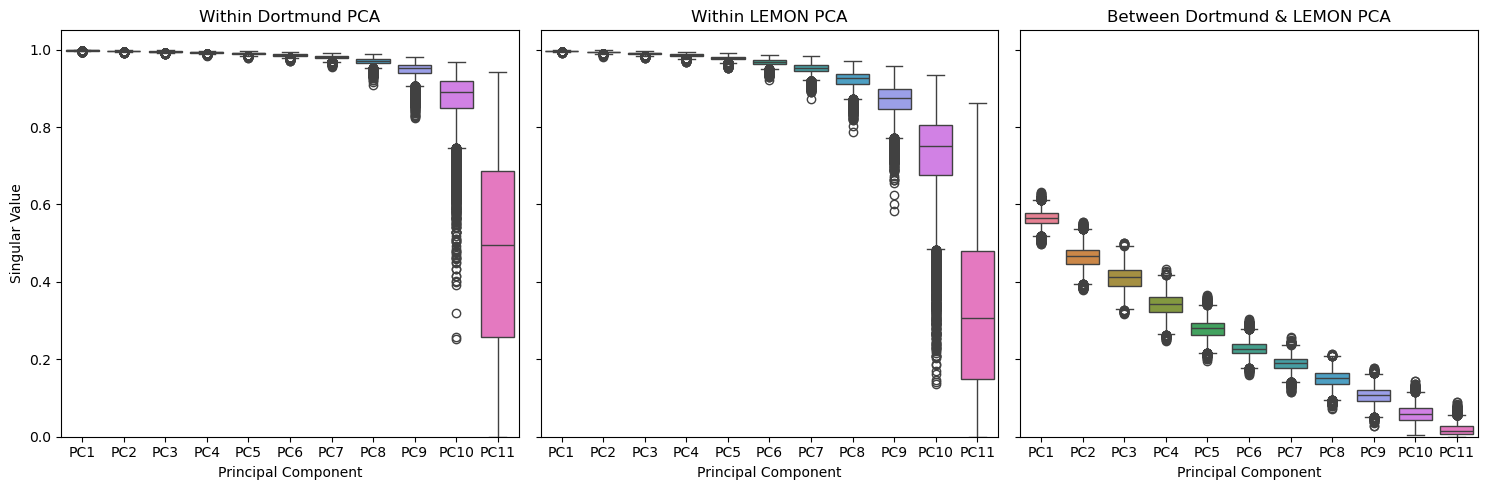

In [51]:
import seaborn as sns

def summarize_bootstrap_results_subplots(results_dicts, titles):
    """
    Plot multiple bootstrap singular value boxplots in subplots.

    results_dicts: list of results dictionaries (e.g., [within_Dortmund, within_Lemon, between_DL])
    titles: list of subplot titles corresponding to each dictionary
    """
    n_plots = len(results_dicts)
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5), sharey=True)

    if n_plots == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, results_dict, title in zip(axes, results_dicts, titles):
        all_svals = np.array(list(results_dict.values()))
        sns.boxplot(data=all_svals, ax=ax)

        n_components = all_svals.shape[1]
        ax.set_xticks(range(n_components))
        ax.set_xticklabels([f"PC{i}" for i in range(1, n_components+1)])

        ax.set_xlabel("Principal Component")
        ax.set_title(title)
        ax.set_ylim(0,1.05)

        # Print mean singular values
        mean_svals = np.mean(all_svals, axis=0)
        print(f"{title} - Mean singular values per component:\n{mean_svals}\n")

    axes[0].set_ylabel("Singular Value")
    plt.tight_layout()
    plt.show()

# Call the function
summarize_bootstrap_results_subplots(
    [results["within_Dortmund"], results["within_Lemon"], results["between_DL"]],
    ["Within Dortmund PCA", "Within LEMON PCA", "Between Dortmund & LEMON PCA"]
)


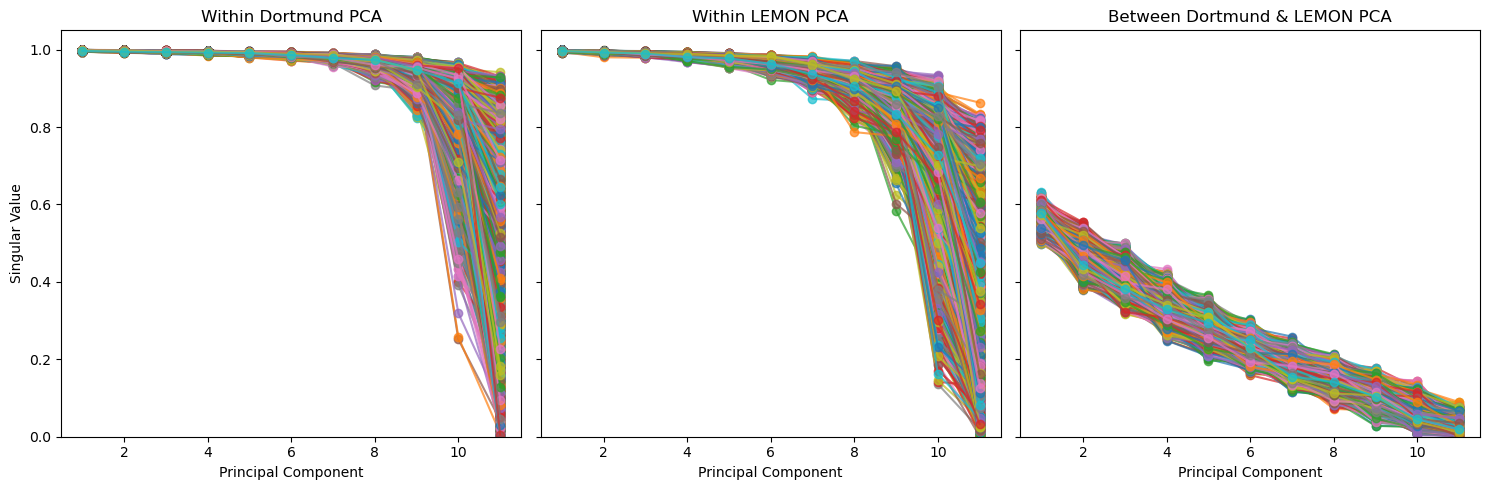

In [52]:
def lineplot_bootstrap_subplot(results_dicts, titles):
    """
    Plot multiple bootstrap singular value lineplots in subplots.

    results_dicts: list of results dictionaries (e.g., [within_Dortmund, within_Lemon, between_DL])
    titles: list of subplot titles corresponding to each dictionary
    """
    n_plots = len(results_dicts)
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5), sharey=True)

    if n_plots == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, results_dict, title in zip(axes, results_dicts, titles):
        all_svals = np.array(list(results_dict.values()))
        for svals in all_svals:
            ax.plot(range(1, len(svals)+1), svals, marker='o', alpha=0.7)
        ax.set_xlabel("Principal Component")
        ax.set_title(title)
        ax.set_ylim(0,1.05)

    axes[0].set_ylabel("Singular Value")  # Only left-most plot needs y-axis label
    plt.tight_layout()
    plt.show()

# Call the function with your results
lineplot_bootstrap_subplot(
    [results["within_Dortmund"], results["within_Lemon"], results["between_DL"]],
    ["Within Dortmund PCA", "Within LEMON PCA", "Between Dortmund & LEMON PCA"]
)


In [53]:
def summary_table_all(results_dicts, labels):
    
    for results_dict, label in zip(results_dicts, labels):
        all_svals = np.array(list(results_dict.values()))
        mean_svals = np.mean(all_svals, axis=0)
        std_svals = np.std(all_svals, axis=0)
        df = pd.DataFrame({
            "Component": range(1, len(mean_svals)+1),
            "Mean Singular Value": mean_svals,
            "Std Dev": std_svals
        })
        print(f"\nSummary for {label}:\n")
        display(df)

summary_table_all(
    [results["within_Dortmund"], results["within_Lemon"], results["between_DL"]],
    ["Within Dortmund", "Within LEMON", "Between Dortmund & LEMON"]
)



Summary for Within Dortmund:



,Component,Mean Singular Value,Std Dev
0,1,0.997871,0.000719
1,2,0.996683,0.000935
2,3,0.995145,0.001220
3,4,0.993178,0.001633
4,5,0.990409,0.002224
5,6,0.986636,0.003113
6,7,0.980987,0.004608
7,8,0.970786,0.007926
8,9,0.948054,0.018491
9,10,0.874927,0.062648



Summary for Within LEMON:



,Component,Mean Singular Value,Std Dev
0,1,0.996973,0.000835
1,2,0.993972,0.001549
2,3,0.990508,0.002257
3,4,0.985649,0.003384
4,5,0.978834,0.005006
5,6,0.968516,0.007582
6,7,0.951404,0.012204
7,8,0.922958,0.020419
8,9,0.869087,0.039100
9,10,0.729148,0.105450



Summary for Between Dortmund & LEMON:



,Component,Mean Singular Value,Std Dev
0,1,0.564670,0.017933
1,2,0.465339,0.026388
2,3,0.410533,0.028681
3,4,0.340960,0.027332
4,5,0.279338,0.023118
5,6,0.227977,0.018662
6,7,0.189835,0.017764
7,8,0.150545,0.020324
8,9,0.107109,0.020280
9,10,0.059214,0.020705


### PCA Stability and Cross-Dataset Comparison (Summary)

- **Within Dortmund:** Principal components are highly stable across bootstrap samples (singular values ≈ 0.47–0.998 for PCs 1–11). Leading PCs are extremely robust, while minor components show lower reproducibility.
- **Within LEMON:** Components are stable overall, with singular values ≈ 0.32–0.997. Top components are highly consistent, whereas the least dominant components vary more across bootstrap samples.
- **Between Dortmund and LEMON:** Singular values are low (≈ 0.018–0.565), indicating that PCA subspaces are largely dataset-specific and not strongly shared.

### Conclusion:
- PCA captures stable variance structure within each dataset but differs substantially between datasets.
- PCA representations should be computed separately for Dortmund and LEMON; a single PCA cannot be reliably applied to both datasets for downstream analyses such as clustering.